## Exp-032 (ULMS BERT)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Sep 15 07:41:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers pycld2

     |████████████████████████████████| 2.8 MB 6.0 MB/s 
     |████████████████████████████████| 41.4 MB 58 kB/s 
     |████████████████████████████████| 895 kB 24.3 MB/s 
     |████████████████████████████████| 636 kB 22.2 MB/s 
     |████████████████████████████████| 52 kB 622 kB/s 
     |████████████████████████████████| 3.3 MB 24.7 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834208 sha256=cc23a44cee2b1fe6beef4fbd8b7a8494be72ec5d9fec98ff41e6de88e912416f
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
input_dir = "/content/drive/MyDrive/07_Competition/signate-471/data/"
output_dir = "/content/drive/MyDrive/07_Competition/signate-471/log/"
submission_dir = "/content/drive/MyDrive/07_Competition/signate-471/submission/"
model_dir = "/content/drive/MyDrive/07_Competition/signate-471/model_bin/"
pred_dir = "/content/drive/MyDrive/07_Competition/signate-471/pred/"

In [ ]:
import os
import math
import random
import pandas as pd
import numpy as np
from glob import glob
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

from transformers import BertConfig, RobertaConfig
from transformers import (get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertModel, RobertaModel
from transformers import AutoConfig, BertConfig, RobertaConfig
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from torch import cuda
import time
import itertools

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
from transformers import get_linear_schedule_with_warmup

from IPython.display import clear_output
from tqdm import tqdm, trange

import re
import nltk
import pycld2 as cld2
from scipy.optimize import minimize, minimize_scalar
import regex
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class CFG:
  exp = "exp32h"
  seed = 71
  fold = 5
  max_len = 280
  epochs = 1
  lr = 2e-5
  train_batch_size = 16
  valid_batch_size = 32
  model_name = "GanjinZero/UMLSBert_ENG"

CONFIG = CFG()

In [ ]:
os.makedirs(model_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(pred_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(output_dir+CONFIG.exp+"/", exist_ok=True)

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

set_random_seed(CONFIG.seed)

In [ ]:
DEVICE = torch.device('cuda') if cuda.is_available() else 'cpu'

In [ ]:
def init_logger(log_file=output_dir + CONFIG.exp+ f"/{CONFIG.exp}_train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [ ]:
def get_train_data(train):
    # 交差検証 用の番号を振ります。
    Fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

def get_test_data(test):
    return test

In [ ]:
class SRWSDataset(Dataset):
  def __init__(self, df, inference_only=False):

    # Berttokenizer
    tokenizer = BertTokenizer.from_pretrained(CONFIG.model_name)

    self.df = df
    self.inference_only = inference_only # "train":False or "test":True
    self.text = self.df["title_abst"].tolist() # text

    if not self.inference_only:
      # ここvalueだけ
      self.target = df["judgement"].values
      
    self.encoded = tokenizer.batch_encode_plus(
        self.text,
        padding = "max_length",
        max_length = CONFIG.max_len,
        truncation = True,
        return_attention_mask=True
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    input_ids = torch.tensor(self.encoded["input_ids"][index])
    attention_mask = torch.tensor(self.encoded["attention_mask"][index])

    # returnをsetかdictで返すかは自由
    if self.inference_only:
      return (input_ids, attention_mask)

    else:
      # ここで、tensor に変更している
      target = torch.tensor(self.target[index]).float()
      return (input_ids, attention_mask, target)


In [ ]:
class SRWSBertModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.config = BertConfig.from_pretrained(CFG.model_name)
    self.config.update({"output_hidden_states": True})
    self.config.hidden_dropout_prob = 0
    self.config.attention_probs_dropout_prob = 0
    self.bert = BertModel.from_pretrained(CONFIG.model_name, config=self.config)
    self.regressor = nn.Linear(self.config.hidden_size*4, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
    sequence_output = torch.cat([output["hidden_states"][-1*i][:,0] for i in range(1, 4+1)], dim=1)
    bert_output = self.regressor(sequence_output)
    bert_output = self.sigmoid(bert_output).squeeze()

    return bert_output

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
# 学習
def train_fn(model, train_loader, optimizer, epoch, loss_function, scheduler=None):
  start = end = time.time()
  losses = AverageMeter()
  model.train()

  for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
    optimizer.zero_grad()

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    pred = model(input_ids, attention_mask)

    # Loss算出
    #print(pred)
    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)
    loss.backward()

    optimizer.step()

    if scheduler:
      scheduler.step()

    if batch_num % 100 == 0 or batch_num == (len(train_loader) -1):
      print(
            f"Epoch: [{epoch + 1}][{batch_num}/{len(train_loader)}] "
            f"Elapsed {timeSince(start, float(batch_num + 1) / len(train_loader)):s} "
            f"Loss: {losses.avg:.4f} "
            )
      
  return losses.avg

def valid_fn(valid_loader, model, loss_function):
  start = end = time.time()
  losses = AverageMeter()

  model.eval()
  preds = []

  for batch_num, (input_ids, attention_mask, target) in enumerate(valid_loader):
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    # compare loss
    with torch.no_grad():
      pred = model(input_ids, attention_mask)

    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)

    # スコア追加
    preds.append(pred.to("cpu").numpy())

    if batch_num % 100 == 0 or batch_num == (len(valid_loader) - 1):
      print(
          f"EVAL: [{batch_num}/{len(valid_loader)}]"
          f"Elapsed {timeSince(start, float(batch_num+1) / len(valid_loader)):s}"
          f"Loss: {losses.avg:.4f}"
      )
  predictions = np.concatenate(preds)

  return losses.avg, predictions

# 予測
def inference():
    predictions = []

    test_dataset = SRWSDataset(test,  inference_only=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG.valid_batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    for fold in range(CONFIG.fold):
        LOGGER.info(f"========== model: {CONFIG.model_name} fold: {fold} inference ==========")
        model = SRWSBertModel()
        model.to(DEVICE)
        model.load_state_dict(torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")["model"])
        model.eval()
        preds = []
        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            with torch.no_grad():
                y_preds = model(input_ids, attention_mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        preds = preds**0.8
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

In [ ]:
# 最適化（使ってない）
# https://signate.jp/competitions/471/discussions/tf-roberta-base-baseline-cv08949-lb08734

def opt_fbeta_threshold(y_true, y_pred):
  """fbeta score計算時のthresholdを最適化"""
  def opt_(x):
    return -fbeta_score(y_true, y_pred >= x, beta=7)
  result = minimize(opt_, x0=np.array([0.02]), method='Powell')
  best_threshold = result['x'].item()
  return best_threshold

In [ ]:
def get_optimizer_grouped_parameters(model):
    model_type = 'bert'
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 1e-3,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = CONFIG.lr
    for layer in layers:
        lr *= 0.95
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.1,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [ ]:
# LOOP
def train_loop(train, fold):
  LOGGER.info(f"========== fold: {fold} training ==========")

  # ====================================================
  # Data Loader
  # ====================================================
  trn_idx = train[train["fold"] != fold].index
  val_idx = train[train["fold"] == fold].index

  train_folds = train.loc[trn_idx].reset_index(drop=True)
  valid_folds = train.loc[val_idx].reset_index(drop=True)

  train_dataset = SRWSDataset(train_folds)
  valid_dataset = SRWSDataset(valid_folds)

  train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, # https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
        drop_last=True,
  )
  valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.valid_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
  )

  # ====================================================
  # Model
  # ====================================================
  model = SRWSBertModel()
  model.to(DEVICE)

  optimizer_parameters = get_optimizer_grouped_parameters(model)

  #optimizer = AdamW(model.parameters(), lr=CONFIG.lr)
  optimizer = AdamW(optimizer_parameters, lr=CONFIG.lr, weight_decay=0.1)

  # Loss_function
  loss_function = nn.BCELoss()

  # ====================================================
  # LOOP
  # ====================================================

  best_score = -1
  best_loss = np.inf
  best_borders=[]

  # 学習
  for epoch in range(CONFIG.epochs):
    start_time = time.time()

    # train
    avg_loss = train_fn(model, train_loader, optimizer, epoch, loss_function)

    # valid
    avg_val_loss, preds = valid_fn(valid_loader, model,loss_function)
    valid_labels = valid_folds["judgement"].values
    preds = preds**0.8

    # border最適化
    border_m = opt_fbeta_threshold(valid_labels, preds)
    best_borders.append(border_m)

    # score
    score = fbeta_score(valid_labels, np.where(preds < border_m, 0, 1), beta=7.0)

    elapsed = time.time() - start_time
    LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
    )
    LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

    if score > best_score:
      best_score = score
      LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} ")
      torch.save(
                {"model": model.state_dict(), "preds": preds}, model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth"
      ) # scibertでの変更
  check_point = torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")

  valid_folds["preds"] = check_point["preds"]

  return valid_folds,best_borders

In [ ]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_threshold))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_threshold, 0, 1), beta=7.0)
    print("Score：" + str(score))
    LOGGER.info(f"Score: {score:<.5f}")

# inference用に、best_thresholdを出力するようにする関数
def get_result_for_cv(result_df,best_border):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    #best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_border))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_border, 0, 1), beta=7.0)
    LOGGER.info(f"Score: {score:<.5f}")

    return score

def mean_best_border(*best_borders):
    best_border = np.mean(best_borders)
    print("Best_Threshold：" + str(best_border))
    LOGGER.info(f"Best_Border: {best_border:<.8f}")

    return best_border

In [ ]:
def clean_stopword(text):
  stopwords = nltk.corpus.stopwords.words('english')
  list_x = text.split()
  res = []
  for w in list_x:
    if w not in stopwords:
      res.append(w)
  return ' '.join(res)

def clean_puncts(x):
  # 化学式とかがあるから '-'は削除しないほうがいいか？

  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
            '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
            '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
            '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
            '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '（', '）', '～',
            '➡', '％', '⇒', '▶', '「', '➄', '➆',  '➊', '➋', '➌', '➍', '⓪', '①', '②', '③', '④', '⑤', '⑰', '❶', '❷', '❸', '❹', '❺', '❻', '❼', '❽',  
            '＝', '※', '㈱', '､', '△', '℮', 'ⅼ', '‐', '｣', '┝', '↳', '◉', '／', '＋', '○',
            '【', '】', '✅', '☑', '➤', 'ﾞ', '↳', '〶', '☛', '｢', '⁺', '『', '≫',
            'Â©', '<sub>','Aﾎｲ', 'ﾎｲ', "ﾃｩ"
          ] 
  # 文字化け対応はここで対応するしかない？
  
  for punct in puncts:
    x = x.replace(punct, '')
  return x

def _pre_preprocess(x):
  return str(x).lower() 

def rm_num(x, use_num=True):
  numbers = ["0","1","2","3","4","5","6","7","8","9","０","１","２","３","４","５","６","７","８","９"]
  x = re.sub('[0-9]{5,}', '', x)
  x = re.sub('[0-9]{4}', '', x)
  x = re.sub('[0-9]{3}', '', x)
  x = re.sub('[0-9]{2}', '', x)    
  for i in numbers:
    x = x.replace(str(i), '')        
  return x

def convert_mojibake(text):
  text = text.encode("shift-jis").decode("utf-8", errors="ignore")
  return text

def remove_double(text):
  text = text.replace("  ", " ")
  return text

def preprocess_text(text):
  #text = _pre_preprocess(text)
  #text = clean_stopword(text)
  text = clean_puncts(text)
  text = rm_num(text)
  text = remove_double(text)

  return text

def split_copyright(text):
  if "Copyright" in text:
    text = text.split('Copyright')[0]
    return text
  else:
    return text


In [ ]:
pd.set_option("display.max_colwidth", 50)
train = pd.read_csv(input_dir + "train.csv")
test = pd.read_csv(input_dir + "test.csv")
sub = pd.read_csv(input_dir + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

In [ ]:
# ラベル変更
# https://signate.jp/competitions/471/discussions/20210816152356-59

train.loc[train["id"]==2488, "judgement"] = 0
train.loc[train["id"]==7708, "judgement"] = 0

In [ ]:
train["title_abst"] = train["title"] + train["abstract"]
train["title_abst"].fillna(train["title"], inplace=True)

test["title_abst"] = test["title"] + test["abstract"]
test["title_abst"].fillna(test["title"], inplace=True)

train.head()

,id,title,abstract,judgement,title_abst
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,Prolonged shedding of SARS-CoV-2 in an elderly...


In [ ]:
# preprocess
train["title_abst"] = train["title_abst"].apply(lambda x: preprocess_text(x))
test["title_abst"] = test["title_abst"].apply(lambda x: preprocess_text(x))

# titleの単語数が3以下のものは除外してみる
train["title_word_len"] = train["title"].str.split(" ").str.len()
train = train[train["title_word_len"]>3]

# titleが他言語の場合は除外
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train = train[(train["title_lang"]=="en")|(train["title_lang"]=="un")]

# copyright以降は削除したい
train["title_abst"] = train["title_abst"].apply(lambda x: split_copyright(x))
test["title_abst"] = test["title_abst"].apply(lambda x: split_copyright(x))

train = train[["id","title","abstract","title_abst","judgement"]]

In [ ]:
train

,id,title,abstract,title_abst,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,Oneyear age changes in MRI brain volumes in ol...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,Supportive CSF biomarker evidence to enhance t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,Occurrence of basal ganglia germ cell tumors w...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,New developments in diagnosis and therapy of C...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,Prolonged shedding of SARSCoV in an elderly li...,0
...,...,...,...,...,...
27140,27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,The amyloidogenic pathway of amyloid precursor...,0
27141,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,Technologic developments in radiotherapy and s...,0
27142,27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,Novel screening cascade identifies MKK as key ...,0
27143,27143,Visualization of the gall bladder on F-18 FDOP...,The ability to label dihydroxyphenylalanine (D...,Visualization of the gall bladder on F FDOPA P...,0


In [ ]:
#Judgement==1 Sampleのオーバーサンプリング
# title, abstのランダムな組み合わせでデータを水増し
index_list = list(train[train.judgement==1].index)
combination_list = list(itertools.combinations(index_list, 2))

select_num = train.judgement.value_counts()[0] - train.judgement.value_counts()[1]
random.seed(CONFIG.seed)
selected_samples = random.sample(combination_list,select_num)
add_df = pd.DataFrame(selected_samples)
add_df.columns=["title_index","abst_index"]

positive_titles = pd.DataFrame(train[train.judgement==1].title)
positive_abstracts = pd.DataFrame(train[train.judgement==1].abstract)

additional_df = pd.merge(add_df,positive_titles,left_on="title_index",right_on=positive_titles.index,how="left")
additional_df = pd.merge(additional_df,positive_abstracts,left_on="abst_index",right_on=positive_abstracts.index,how="left")
additional_df["title_abst"] = additional_df["title"] + additional_df["abstract"]
additional_df["title_abst"].fillna(additional_df["title"], inplace=True)
additional_df["judgement"] =1
additional_df["id"] =additional_df.index

additional_df = additional_df[["id","title","abstract","title_abst","judgement"]]

In [ ]:
additional_df

,id,title,abstract,title_abst,judgement
0,0,Chest CT in patients with a moderate or high p...,The COVID-19 infection is increasing at a rapi...,Chest CT in patients with a moderate or high p...,1
1,1,Coronavirus disease 2019 (COVID-19): chest CT ...,NaN,Coronavirus disease 2019 (COVID-19): chest CT ...,1
2,2,Utility of the FebriDx point-of-care test for ...,BACKGROUND: Comparative data of SARS-CoV-2 IgM...,Utility of the FebriDx point-of-care test for ...,1
3,3,Title: Utility of Repeat Testing for COVID-19:...,Purpose To present a method that automatically...,Title: Utility of Repeat Testing for COVID-19:...,1
4,4,Brief clinical evaluation of six high-throughp...,PURPOSE: 3'-Deoxy-3'-[18F]fluorothymidine ([18...,Brief clinical evaluation of six high-throughp...,1
...,...,...,...,...,...
25668,25668,A gallium scintigraphy of fever of unknown origin,Introduction In this study we aimed to determ...,A gallium scintigraphy of fever of unknown ori...,1
25669,25669,Reducing false negatives in COVID-19 testing b...,The first cases of Coronavirus of 2019 (COVID-...,Reducing false negatives in COVID-19 testing b...,1
25670,25670,From community-acquired pneumonia to COVID-19:...,BACKGROUND The global outbreak of human severe...,From community-acquired pneumonia to COVID-19:...,1
25671,25671,Development of a sensitive immunochromatograph...,NaN,Development of a sensitive immunochromatograph...,1


In [ ]:
train = pd.concat([train,additional_df],axis=0).reset_index(drop=True)
train["id"] = train.index

In [ ]:
train

,id,title,abstract,title_abst,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,Oneyear age changes in MRI brain volumes in ol...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,Supportive CSF biomarker evidence to enhance t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,Occurrence of basal ganglia germ cell tumors w...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,New developments in diagnosis and therapy of C...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,Prolonged shedding of SARSCoV in an elderly li...,0
...,...,...,...,...,...
52589,52589,A gallium scintigraphy of fever of unknown origin,Introduction In this study we aimed to determ...,A gallium scintigraphy of fever of unknown ori...,1
52590,52590,Reducing false negatives in COVID-19 testing b...,The first cases of Coronavirus of 2019 (COVID-...,Reducing false negatives in COVID-19 testing b...,1
52591,52591,From community-acquired pneumonia to COVID-19:...,BACKGROUND The global outbreak of human severe...,From community-acquired pneumonia to COVID-19:...,1
52592,52592,Development of a sensitive immunochromatograph...,NaN,Development of a sensitive immunochromatograph...,1


In [ ]:
train.judgement.value_counts()

1    26297
0    26297
Name: judgement, dtype: int64

In [ ]:
train = get_train_data(train)
train.head()

,id,title,abstract,title_abst,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,Oneyear age changes in MRI brain volumes in ol...,0,4
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,Supportive CSF biomarker evidence to enhance t...,0,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,Occurrence of basal ganglia germ cell tumors w...,0,2
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,New developments in diagnosis and therapy of C...,0,1
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,Prolonged shedding of SARSCoV in an elderly li...,0,0


In [ ]:
train[train.title_abst.isnull()]

,id,title,abstract,title_abst,judgement,fold


In [ ]:
# Training
#border = len(train[train["judgement"] == 1]) / len(train["judgement"]) # 0.023245467689912133
#border = border * 0.6

mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df.csv", index=False)

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch: [1][0/2629] Elapsed 0m 1s (remain 48m 1s) Loss: 0.7717 
Epoch: [1][100/2629] Elapsed 1m 21s (remain 33m 49s) Loss: 0.1245 
Epoch: [1][200/2629] Elapsed 2m 48s (remain 33m 51s) Loss: 0.0866 
Epoch: [1][300/2629] Elapsed 4m 19s (remain 33m 24s) Loss: 0.0755 
Epoch: [1][400/2629] Elapsed 5m 53s (remain 32m 42s) Loss: 0.0630 
Epoch: [1][500/2629] Elapsed 7m 28s (remain 31m 45s) Loss: 0.0564 
Epoch: [1][600/2629] Elapsed 9m 4s (remain 30m 35s) Loss: 0.0552 
Epoch: [1][700/2629] Elapsed 10m 39s (remain 29m 19s) Loss: 0.0534 
Epoch: [1][800/2629] Elapsed 12m 15s (remain 27m 57s) Loss: 0.0522 
Epoch: [1][900/2629] Elapsed 13m 49s (remain 26m 31s) Loss: 0.0485 
Epoch: [1][1000/2629] Elapsed 15m 24s (remain 25m 4s) Loss: 0.0464 
Epoch: [1][1100/2629] Elapsed 17m 0s (remain 23m 35s) Loss: 0.0453 
Epoch: [1][1200/2629] Elapsed 18m 35s (remain 22m 6s) Loss: 0.0432 
Epoch: [1][1300/2629] Elapsed 20m 10s (remain 20m 35s) Loss: 0.0422 
Epoch: [1][1400/2629] Elapsed 21m 45s (remain 19m 4s) Loss:

Epoch 1 - avg_train_loss: 0.0371  avg_val_loss: 0.0264  time: 2677s
Epoch 1 - Score: 0.9971455828750178
Epoch 1 - Save Best Score: 0.9971 
========== fold: 0 result ==========
Best_Border: 0.02559928
========== fold: 1 training ==========


Best_Threshold：0.02559927759945282


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/2629] Elapsed 0m 0s (remain 43m 19s) Loss: 0.8520 
Epoch: [1][100/2629] Elapsed 1m 25s (remain 35m 30s) Loss: 0.1290 
Epoch: [1][200/2629] Elapsed 2m 55s (remain 35m 14s) Loss: 0.0981 
Epoch: [1][300/2629] Elapsed 4m 27s (remain 34m 28s) Loss: 0.0798 
Epoch: [1][400/2629] Elapsed 6m 2s (remain 33m 31s) Loss: 0.0700 
Epoch: [1][500/2629] Elapsed 7m 37s (remain 32m 22s) Loss: 0.0617 
Epoch: [1][600/2629] Elapsed 9m 12s (remain 31m 5s) Loss: 0.0577 
Epoch: [1][700/2629] Elapsed 10m 48s (remain 29m 42s) Loss: 0.0582 
Epoch: [1][800/2629] Elapsed 12m 23s (remain 28m 16s) Loss: 0.0547 
Epoch: [1][900/2629] Elapsed 13m 59s (remain 26m 49s) Loss: 0.0499 
Epoch: [1][1000/2629] Elapsed 15m 33s (remain 25m 18s) Loss: 0.0467 
Epoch: [1][1100/2629] Elapsed 17m 9s (remain 23m 48s) Loss: 0.0458 
Epoch: [1][1200/2629] Elapsed 18m 44s (remain 22m 16s) Loss: 0.0444 
Epoch: [1][1300/2629] Elapsed 20m 19s (remain 20m 44s) Loss: 0.0429 
Epoch: [1][1400/2629] Elapsed 21m 54s (remain 19m 12s) Lo

Epoch 1 - avg_train_loss: 0.0361  avg_val_loss: 0.0236  time: 2684s
Epoch 1 - Score: 0.9976113530982155
Epoch 1 - Save Best Score: 0.9976 
========== fold: 1 result ==========
Best_Border: 0.07306003
========== fold: 2 training ==========


Best_Threshold：0.07306002658043045


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/2629] Elapsed 0m 1s (remain 45m 20s) Loss: 0.7550 
Epoch: [1][100/2629] Elapsed 1m 25s (remain 35m 29s) Loss: 0.1083 
Epoch: [1][200/2629] Elapsed 2m 54s (remain 35m 13s) Loss: 0.0943 
Epoch: [1][300/2629] Elapsed 4m 27s (remain 34m 31s) Loss: 0.0737 
Epoch: [1][400/2629] Elapsed 6m 2s (remain 33m 35s) Loss: 0.0630 
Epoch: [1][500/2629] Elapsed 7m 38s (remain 32m 27s) Loss: 0.0586 
Epoch: [1][600/2629] Elapsed 9m 13s (remain 31m 7s) Loss: 0.0560 
Epoch: [1][700/2629] Elapsed 10m 48s (remain 29m 44s) Loss: 0.0553 
Epoch: [1][800/2629] Elapsed 12m 23s (remain 28m 17s) Loss: 0.0544 
Epoch: [1][900/2629] Elapsed 13m 59s (remain 26m 49s) Loss: 0.0520 
Epoch: [1][1000/2629] Elapsed 15m 34s (remain 25m 20s) Loss: 0.0495 
Epoch: [1][1100/2629] Elapsed 17m 8s (remain 23m 47s) Loss: 0.0476 
Epoch: [1][1200/2629] Elapsed 18m 40s (remain 22m 12s) Loss: 0.0463 
Epoch: [1][1300/2629] Elapsed 20m 13s (remain 20m 38s) Loss: 0.0450 
Epoch: [1][1400/2629] Elapsed 21m 48s (remain 19m 6s) Los

Epoch 1 - avg_train_loss: 0.0368  avg_val_loss: 0.0386  time: 2655s
Epoch 1 - Score: 0.997726315150181
Epoch 1 - Save Best Score: 0.9977 
========== fold: 2 result ==========
Best_Border: 0.16983669
========== fold: 3 training ==========


Best_Threshold：0.16983668887503328


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/2629] Elapsed 0m 1s (remain 43m 49s) Loss: 0.6608 
Epoch: [1][100/2629] Elapsed 1m 25s (remain 35m 28s) Loss: 0.1190 
Epoch: [1][200/2629] Elapsed 2m 55s (remain 35m 16s) Loss: 0.0859 
Epoch: [1][300/2629] Elapsed 4m 28s (remain 34m 35s) Loss: 0.0732 
Epoch: [1][400/2629] Elapsed 6m 3s (remain 33m 40s) Loss: 0.0688 
Epoch: [1][500/2629] Elapsed 7m 39s (remain 32m 30s) Loss: 0.0609 
Epoch: [1][600/2629] Elapsed 9m 14s (remain 31m 10s) Loss: 0.0592 
Epoch: [1][700/2629] Elapsed 10m 49s (remain 29m 46s) Loss: 0.0563 
Epoch: [1][800/2629] Elapsed 12m 24s (remain 28m 19s) Loss: 0.0539 
Epoch: [1][900/2629] Elapsed 13m 59s (remain 26m 50s) Loss: 0.0517 
Epoch: [1][1000/2629] Elapsed 15m 34s (remain 25m 20s) Loss: 0.0494 
Epoch: [1][1100/2629] Elapsed 17m 9s (remain 23m 49s) Loss: 0.0478 
Epoch: [1][1200/2629] Elapsed 18m 44s (remain 22m 17s) Loss: 0.0471 
Epoch: [1][1300/2629] Elapsed 20m 18s (remain 20m 43s) Loss: 0.0458 
Epoch: [1][1400/2629] Elapsed 21m 52s (remain 19m 10s) L

Epoch 1 - avg_train_loss: 0.0366  avg_val_loss: 0.0188  time: 2674s
Epoch 1 - Score: 0.9972543226379769
Epoch 1 - Save Best Score: 0.9973 
========== fold: 3 result ==========
Best_Border: 0.02269003
========== fold: 4 training ==========


Best_Threshold：0.022690034504541903


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [1][0/2629] Elapsed 0m 0s (remain 43m 37s) Loss: 0.8064 
Epoch: [1][100/2629] Elapsed 1m 24s (remain 35m 24s) Loss: 0.1476 
Epoch: [1][200/2629] Elapsed 2m 54s (remain 35m 9s) Loss: 0.0988 
Epoch: [1][300/2629] Elapsed 4m 27s (remain 34m 25s) Loss: 0.0821 
Epoch: [1][400/2629] Elapsed 6m 1s (remain 33m 29s) Loss: 0.0706 
Epoch: [1][500/2629] Elapsed 7m 37s (remain 32m 21s) Loss: 0.0635 
Epoch: [1][600/2629] Elapsed 9m 12s (remain 31m 3s) Loss: 0.0598 
Epoch: [1][700/2629] Elapsed 10m 47s (remain 29m 40s) Loss: 0.0544 
Epoch: [1][800/2629] Elapsed 12m 22s (remain 28m 14s) Loss: 0.0548 
Epoch: [1][900/2629] Elapsed 13m 57s (remain 26m 45s) Loss: 0.0522 
Epoch: [1][1000/2629] Elapsed 15m 32s (remain 25m 15s) Loss: 0.0497 
Epoch: [1][1100/2629] Elapsed 17m 7s (remain 23m 45s) Loss: 0.0496 
Epoch: [1][1200/2629] Elapsed 18m 42s (remain 22m 14s) Loss: 0.0479 
Epoch: [1][1300/2629] Elapsed 20m 17s (remain 20m 42s) Loss: 0.0467 
Epoch: [1][1400/2629] Elapsed 21m 51s (remain 19m 9s) Loss

Epoch 1 - avg_train_loss: 0.0366  avg_val_loss: 0.0237  time: 2676s


EVAL: [328/329]Elapsed 3m 30s (remain 0m 0s)Loss: 0.0237


Epoch 1 - Score: 0.9979971648671554
Epoch 1 - Save Best Score: 0.9980 
========== fold: 4 result ==========
Best_Border: 0.02346031
========== CV ==========
Best_Border: 0.06292927
Score: 0.99653


Best_Threshold：0.023460313105275108
Best_Threshold：0.06292926813294672
Best_Threshold：0.06292926813294672


In [ ]:
best_border =0.06292926813294672

In [ ]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission.csv", index=False, header=False)

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

100%|██████████| 1277/1277 [24:30<00:00,  1.15s/it]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [24:29<00:00,  1.15s/it]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [24:30<00:00,  1.15s/it]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [24:31<00:00,  1.15s/it]
========== model: GanjinZero/UMLSBert_ENG fold: 4 inference ==========
100%|██████████| 1277/1277 [24:30<00:00,  1.15s/it]


In [ ]:
pred_df=pd.read_csv(pred_dir +CONFIG.exp + "/pred_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


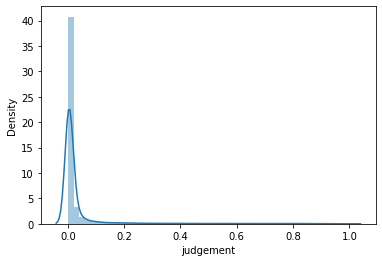

In [ ]:
import seaborn as sns
sns.distplot(pred_df["judgement"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


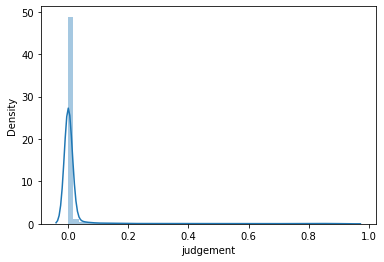

In [ ]:
sns.distplot(pred_df["judgement"])

In [ ]:
oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


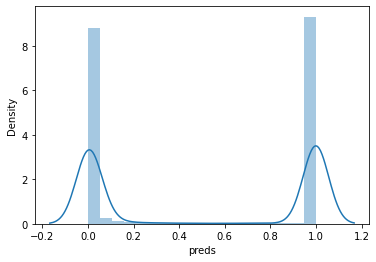

In [ ]:
import seaborn as sns
sns.distplot(oof_df["preds"])

In [ ]:
oof_df

,id,title,abstract,judgement,fold,title_abst,title_word_len,title_lang,preds
0,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...,13,en,0.008044
1,8,Rehabilitation and Covid-19: the Cochrane Reha...,INTRODUCTION: This paper improves the methodol...,0,0,Rehabilitation and Covid the Cochrane Rehabili...,11,en,0.004878
2,25,"COVID-19, impact on myeloma patients",NaN,0,0,COVID impact on myeloma patients,5,en,0.000690
3,26,SARS-CoV-2 Positive Hospitalized Cancer Patien...,In the coronavirus disease (COVID-19) pandemic...,0,0,SARSCoV Positive Hospitalized Cancer Patients ...,15,en,0.000190
4,27,Value of echographic examination in the study ...,Beside conventional radiology and bone scintig...,0,0,Value of echographic examination in the study ...,9,en,0.009271
...,...,...,...,...,...,...,...,...,...
26916,27123,Utility of the combination of DAT SPECT and MI...,Purpose: 123I-2β-Carbomethoxy-3β-(4-iodophenyl...,1,4,Utility of the combination of DAT SPECT and MI...,20,en,0.890052
26917,27130,Tocilizumab use in COVID -19 associated pneumonia,BACKGROUND: We sought to evaluate the effect o...,0,4,Tocilizumab use in COVID associated pneumoniaB...,7,en,0.000052
26918,27138,Mortality of high-risk orthopaedic oncology pa...,BACKGROUND AND OBJECTIVES: Should the threshol...,0,4,Mortality of highrisk orthopaedic oncology pat...,14,en,0.000035
26919,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0,4,Technologic developments in radiotherapy and s...,7,en,0.000340


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


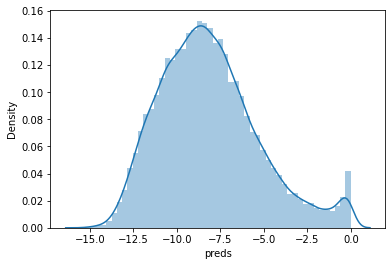

In [ ]:
sns.distplot(np.log(oof_df["preds"]))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


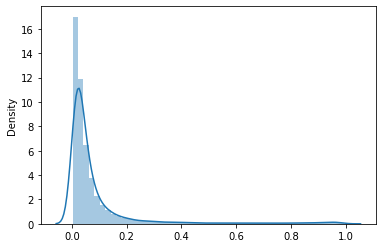

In [ ]:
sns.distplot(oof_df["preds"].values ** 0.4)